In [1]:
import gensim.models
from gensim import utils
from gensim.test.utils import datapath
from gensim.models.fasttext import FastText


## Word2Vec

In [2]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = datapath('C:/Users/hanzh/OneDrive/Documents/Personal--Projects/Analysis--Brexit-Polarity-Tweets/data/splits/train_tweets_token.csv')
        first_line = True
        for line in open(corpus_path):
            if first_line:
                first_line = False
                continue
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

In [3]:
sentences = MyCorpus()

In [4]:
model_word2vec = gensim.models.Word2Vec(sentences=sentences, vector_size = 300)

In [5]:
for index, word in enumerate(model_word2vec.wv.index_to_key):
    if index == 10:
        break
    print(f"word #{index}/{len(model_word2vec.wv.index_to_key)} is {word}")

word #0/30405 is brexit
word #1/30405 is eu
word #2/30405 is uk
word #3/30405 is europe
word #4/30405 is johnson
word #5/30405 is ukraine
word #6/30405 is people
word #7/30405 is country
word #8/30405 is boris
word #9/30405 is russian


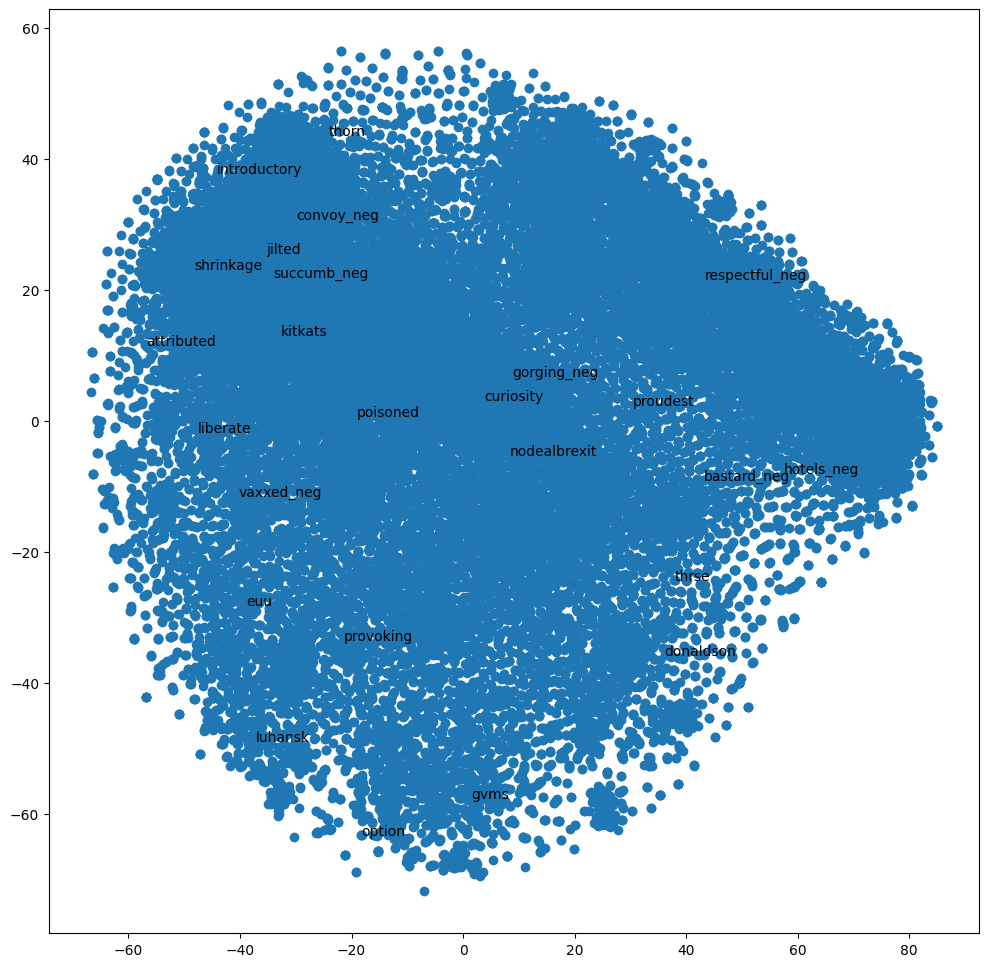

In [6]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling


def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model_word2vec)

def plot(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot(x_vals, y_vals, labels)

## FastText

In [7]:
corpus_file = datapath('C:/Users/hanzh/OneDrive/Documents/Personal--Projects/Analysis--Brexit-Polarity-Tweets/data/splits/train_tweets_token.csv')

In [8]:
model_fasttext = FastText(vector_size = 300)
model_fasttext.build_vocab(corpus_file = corpus_file)
model_fasttext.train(
    corpus_file=corpus_file, 
    epochs=model_fasttext.epochs,
    total_examples=model_fasttext.corpus_count, 
    total_words=model_fasttext.corpus_total_words,
)

(26259632, 28348740)

## Neural Network

In [66]:
import nltk
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, TextVectorization, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder

In [56]:
# path to data
PATH_DATA         = "./data/"

# paths to train-test data
PATH_TRAIN_TWEETS_TOKEN = PATH_DATA + "splits/train_tweets_token.csv"
PATH_TEST_TWEETS_TOKEN = PATH_DATA + "splits/test_tweets_token.csv"

PATH_TRAIN_TARGETS      = PATH_DATA + "splits/train_targets.csv"
PATH_TEST_TARGETS      = PATH_DATA + "splits/test_targets.csv"

# paths to model checkpoints
PATH_MODEL_1      = "./model/model_1/"
PATH_MODEL_2      = "./model/model_2/"

# settings
EMBEDDING_DIMS = 300
SEQ_LENGTH     = 150
OOV_LENGTH     = 1

In [57]:
X_train = pd.read_csv(PATH_TRAIN_TWEETS_TOKEN, index_col = False)["Hit Sentence"]

In [58]:
label_encoder = LabelEncoder()

y_train = pd.read_csv(PATH_TRAIN_TARGETS)["0"]
y_test  = pd.read_csv(PATH_TEST_TARGETS)["0"]

y_train = label_encoder.fit_transform(y_train)

In [59]:
fd = nltk.FreqDist()
for token_list in X_train.map(lambda x: x.split(" ")):
    for token in token_list:
        fd[token] += 1

In [60]:
vocab   = [token for token, count in fd.items()]
values  = range(2, len(vocab) + 2)

init = tf.lookup.KeyValueTensorInitializer(vocab,
                                           values,
                                           key_dtype = tf.string,
                                           value_dtype = tf.int64)

vocab_table = tf.lookup.StaticVocabularyTable(init, OOV_LENGTH)

In [61]:
preprocess = TextVectorization(max_tokens = len(fd) + 2,
                               output_sequence_length = SEQ_LENGTH,
                               output_mode = 'int',
                               vocabulary  = vocab)

X_train = preprocess(X_train)

In [69]:
model_neuralnet = Sequential([
    Embedding(len(fd) + 2, 300, input_shape = (SEQ_LENGTH,)),
    GlobalAveragePooling1D(),
    Dense(1, activation = "sigmoid")
])

model_neuralnet.compile(optimizer = 'adam', loss = "BinaryCrossentropy", metrics = ['accuracy'])

In [71]:
history = model_neuralnet.fit(X_train, y_train, epochs = 10, verbose = 1)

Epoch 1/15
 800/8926 [=>............................] - ETA: 2:40 - loss: 0.4274 - accuracy: 0.8045

KeyboardInterrupt: 